In [2]:
# Importar librerías.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
sns.set_style("darkgrid")

### Descripción del dataset.
- Diseñado para examinar factore que influencian sobre el rendimiento académico
- Contiene información de 10.000 alumnos. 
- Los features que tenemos son:
  - **Horas estudiadas**: horas totales estudiades por cada alumno
  - **Notas previas**: La media de las notas obtenidas en exámenes previos
  - **Actividades extracurriculares**: Si el alumno participa o no
  - **Horas de sueño**: la media de hora de sueño de cada alumno
  - **Simulacros de examen**: número de simulacros de examen realizados 
- Por otra parte, la variable *target* es el índice de rendimiento obtenido.

In [4]:
np.random.seed(42)
df = pd.read_csv("Student_Performance.csv").sample(500)
print(f"El shape del df es: {df.shape}")
df.head()

El shape del df es: (500, 6)


,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
6252,5,69,No,8,2,51.0
4684,2,46,Yes,4,8,20.0
1731,7,56,Yes,7,5,46.0
4742,6,42,Yes,8,5,28.0
4521,7,53,No,4,6,41.0


Tenemos 6 características de 500 alumnos.

In [3]:
# No hay missing data en nuestro df.
null_values = df.isnull().sum().sum()
print(f"Hay {null_values} valores nulos")

# Si que hay duplicados, pero no los voy a eliminar.
duplicados = df.duplicated().sum()
print(f"Hay {duplicados} filas duplicadas.")

Hay 0 valores nulos
Hay 0 filas duplicadas.


- A pesar de haber 127 filas duplicadas no las voy a eliminar.
- Como hay 10000 alumnos es posible que haya duplicados, por tanto, no los voy a eliminar, ya que es algo que puede ocurrir en la realidad.

### Columna categórica.
- Para ganar intuición acerca de la *target* variable voy a crear una columna categórica.
- Las clases de la columna serán las siguientes:
  - **<50**: alumnos con menos de 50 puntos en *Performance index*
  - **50<x<70**: alumnos con una puntuación entre 50 y 70
  - **70<x<90**: alumnos con una puntuación entre 70 y 90
  - **90<x<100**: alumnos con una puntuación entre 90 y 100

In [10]:
# Creamos las categorías de nuestra columna.
new_performance_col = df["Performance Index"].copy()
new_performance_col[df["Performance Index"] <= 100] = "90<x<=100"
new_performance_col[df["Performance Index"] <= 90] = "70<x<=90"
new_performance_col[df["Performance Index"] <= 70] = "50<x<=70"
new_performance_col[df["Performance Index"] <= 50] = "x<=50"
df["Performance Index Categories"] = new_performance_col

# Cuantos alumnos hay en cada categoría.
df["Performance Index Categories"].value_counts()

x<=50        218
50<x<=70     160
70<x<=90     113
90<x<=100      9
Name: Performance Index Categories, dtype: int64

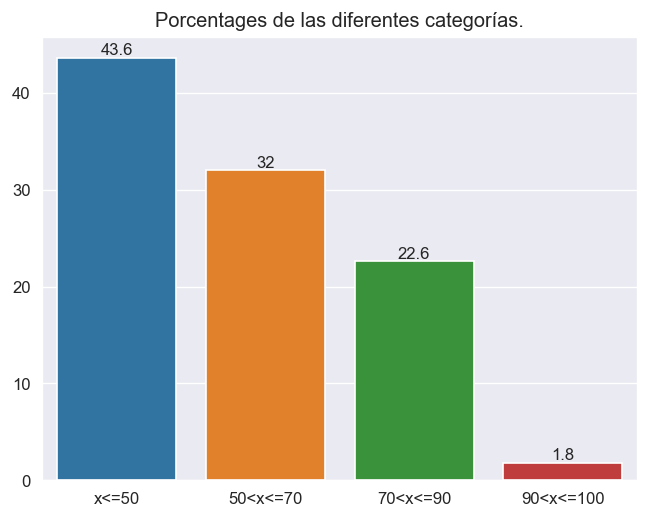

In [13]:
# Diferents percentages of categories
percentages = df["Performance Index Categories"].value_counts()/df.shape[0] * 100
plt.figure(dpi=120)
bar = sns.barplot(x=percentages.index, y=percentages.values)
bar.bar_label(bar.containers[0])
bar.set_title("Porcentages de las diferentes categorías.");

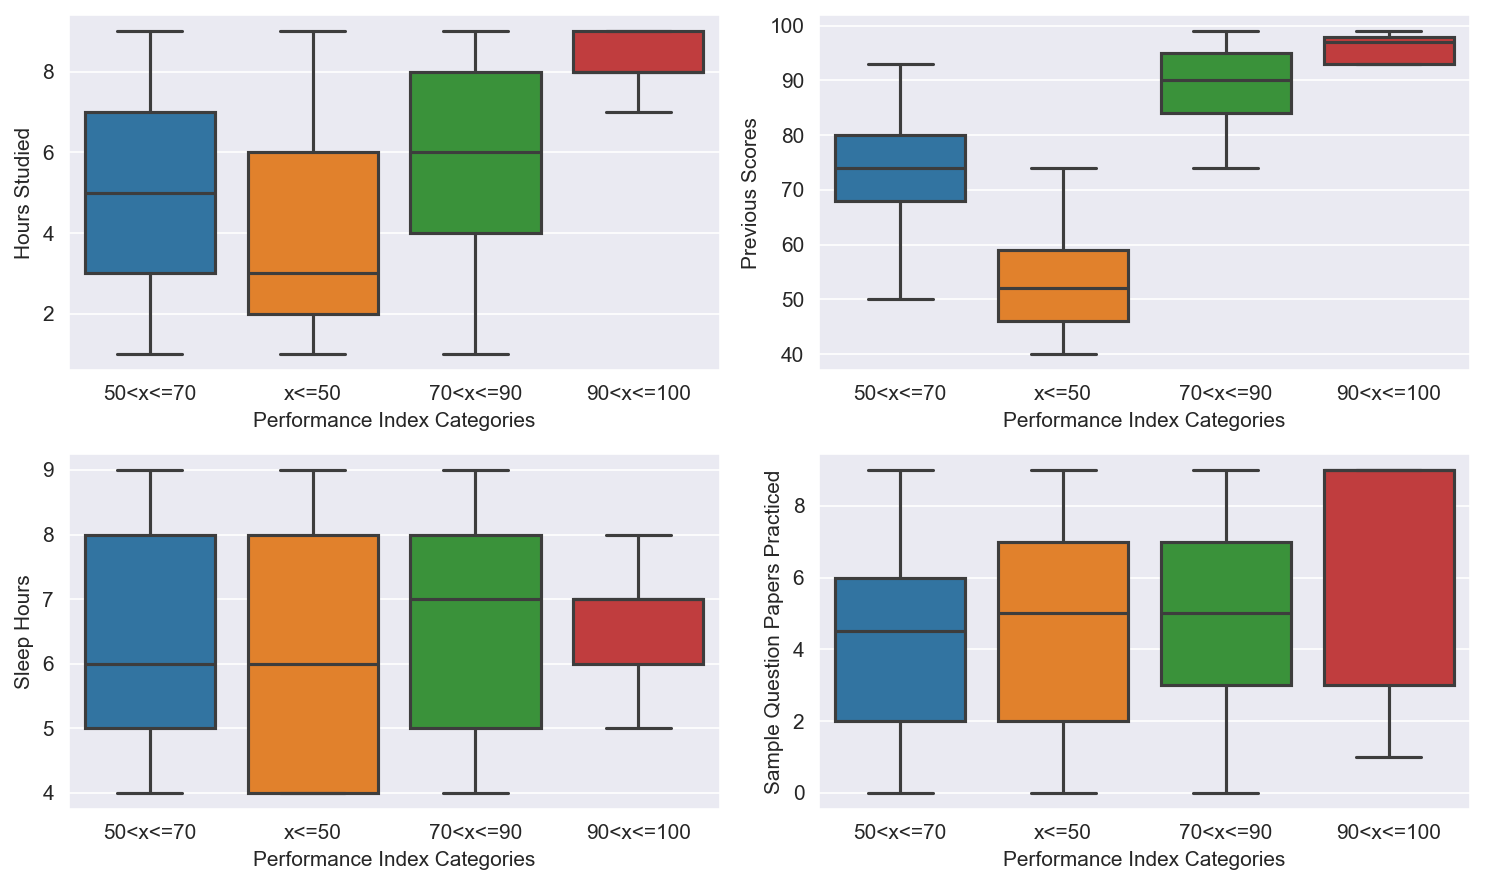

In [6]:
# num_feat = features numéricos
num_feat = [col for col in df.columns if (df[col].dtype != "O" and col != "Performance Index")]

# Representamos media de cada categoría en cada num_feat
fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6), dpi=150)

for index in range(len(num_feat)):
    ax = axes[0][index] if index<2 else axes[1][index - 2]
    bar = sns.boxplot(x=df["Performance Index Categories"], y=df[num_feat[index]], ax=ax)

plt.tight_layout()

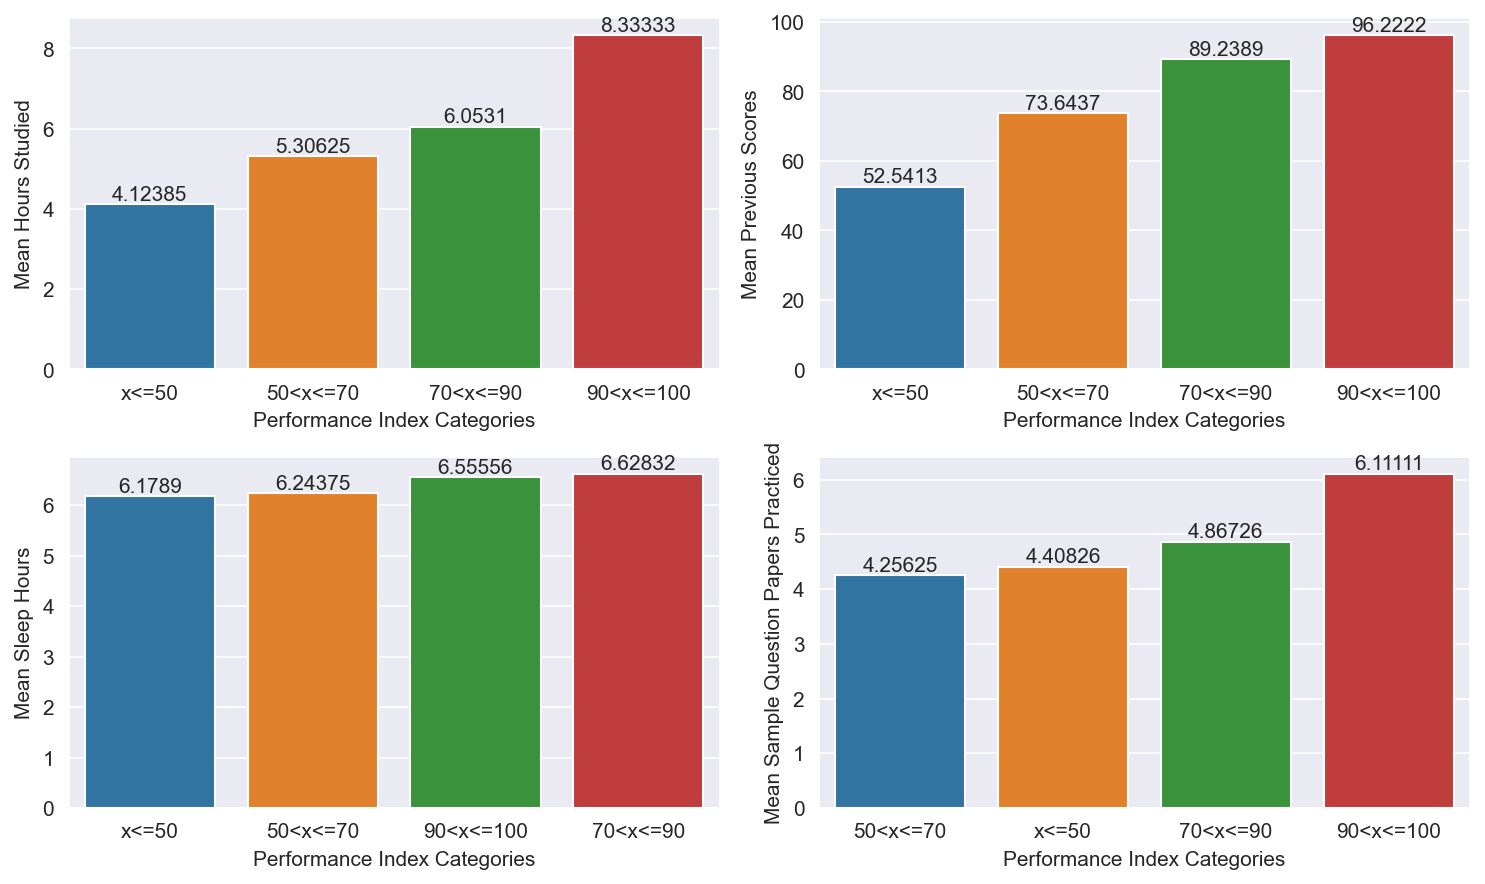

In [14]:
# num_feat = features numéricos
num_feat = [col for col in df.columns if (df[col].dtype != "O" and col != "Performance Index")]

# Representamos media de cada categoría en cada num_feat
fig,axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 6), dpi=150)

for index in range(len(num_feat)):
    # Medias de categorías en cada columna
    means = df.groupby("Performance Index Categories")[num_feat[index]].mean().sort_values()

    # Representación con gráfico de barras
    ax = axes[0][index] if index<2 else axes[1][index - 2]
    bar = sns.barplot(x=means.index, y=means.values, ax=ax)
    bar.bar_label(bar.containers[0])
    ax.set_ylabel(f"Mean {means.name}")

plt.tight_layout()

¿Qué hemos aprendido?:
- Las variables de horas de estudio y notas previas afectan mucho al rendimiento en el examen que estamos estudiando.
- Las variables de horas de sueño y de número de simulacros realizados tienen una menos conexión con las diferentes categorías de alumnos.

Text(0.5, 1.0, 'Porcentaje de alumnos que hacen extracurriculares')

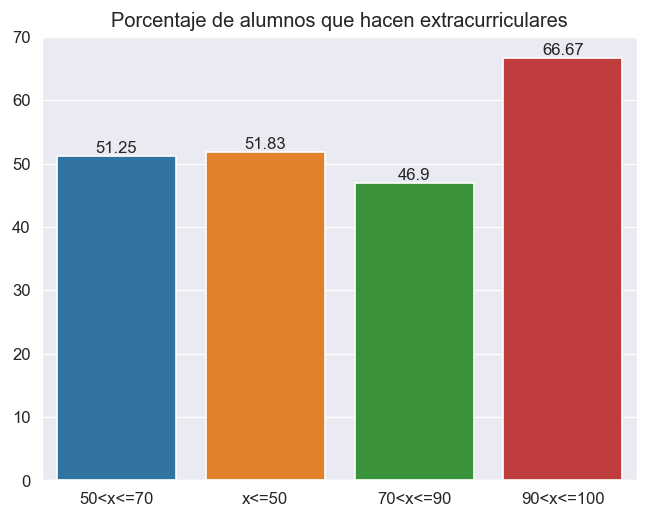

In [15]:
# Categorias de Performance_index_cat y columna que queremos analizar segun categorias
categories = df["Performance Index Categories"].unique()
col_to_analize = "Extracurricular Activities"

# Lista que guarda porcentages de Yes por categoria
percentanges = []

# Loop over categories
for cat in categories:
    # Value counts per cat in the col to analize
    value_counts_cat = df.groupby("Performance Index Categories")[col_to_analize].value_counts()[cat]
    # Total count of values in that cat
    total_in_that_cat = df["Performance Index Categories"].value_counts()[cat]
    # Percentage of students with "Yes" in that cat
    percentage_yes = round((value_counts_cat["Yes"]/total_in_that_cat)*100, 2)
    percentanges.append(percentage_yes)

# Bar plots
plt.figure(dpi=120)
ax = sns.barplot(x=categories, y=percentanges)
ax.bar_label(ax.containers[0])
ax.set_title("Porcentaje de alumnos que hacen extracurriculares")

El porcentaje de alumnos que hacen actividades extracurriculares es más elevado que el resto en la categoría de *90<x<100*, aunque realmente están todos muy igualados en un 50%. 


### Columna numérica.
Ya hemos analizado un poco los datos según la columna categórica, sin embargo, el objetivo es construir un modelo que nos ayude a predecir la *performance index* de un alumno según los features que nos ofrece el dataset. Ahora es momento de analizar esta columna numérica y de ver que *features* son los que más relación guardan con esta variable.

In [9]:
# Algunas estadísticas interesantes sobre la columna que queremos estudiar.
df.describe()["Performance Index"]

count    500.000000
mean      54.050000
std       19.943595
min       11.000000
25%       38.750000
50%       55.000000
75%       70.000000
max       97.000000
Name: Performance Index, dtype: float64

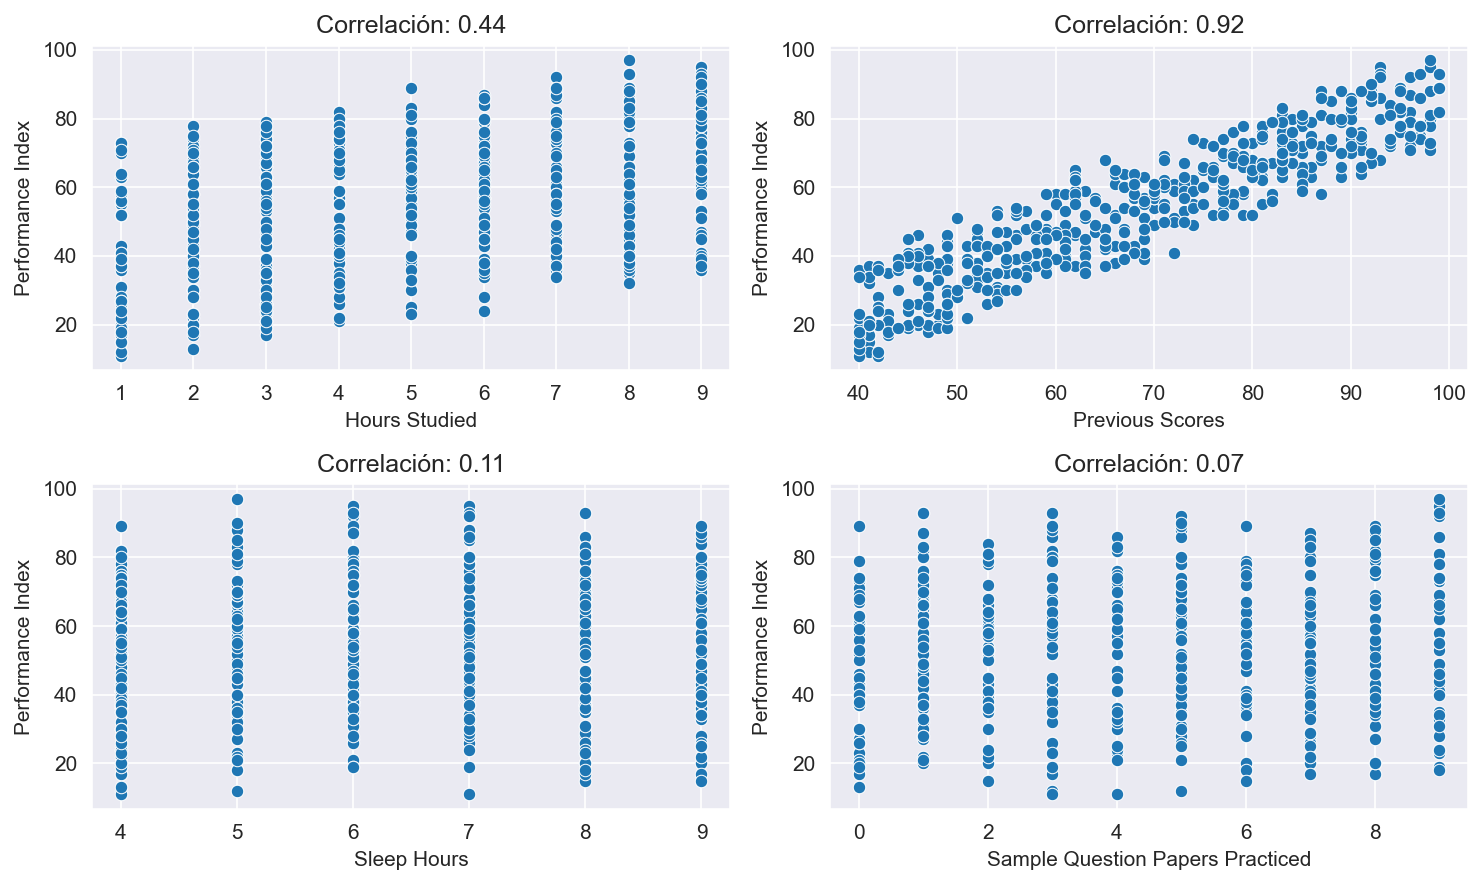

In [16]:
fig,axes = plt.subplots(nrows=2, ncols=2, dpi=150, figsize=(10, 6))
for index in range(len(num_feat)):
    ax = axes[0][index] if index<2 else axes[1][index - 2]
    scat = sns.scatterplot(x=df[num_feat[index]], y=df["Performance Index"], ax=ax)
    scat.set_title(f"Correlación: {df.corr(numeric_only=True)['Performance Index'][num_feat[index]]:.2f}")
plt.tight_layout()

Las variables que más se correlacionan con el *Performance Index* son claramente las *Horas estudiadas* y las *Notas previas* obtenidas en otros exámenes. 

### Construyendo el modelo.
Vamos aplicar el algoritmo de la regresión lineal. Con este algoritmo construiremos una función o **modelo** $f:\mathbb{R}^4\to\mathbb{R}$ que nos servirá para predecir. Así, si un alumno viene descrito por un vector $x=(x_1,x_2,x_3,x_4)$ donde $x_1$ nos dice el número de horas estudiadas; $x_2$ nos dice la nota sacada en exámenes previos; $x_3$ son la horas que duerme de media y $x_4$ son los simulacros de examen que ha practicado, podremos usar nuestro modelo $f$ para predecir la nota que sacará nuestro alumno y que denotaremos por $f(x)=y$. El modelo $f$ verifica que $$f(x)=w\cdot x +b$$ donde $w\cdot x$ es el producto punto entre un vector $x\in \mathbb{R}^4$ que describe a un alumno y un vector $w=(w_1,...,w_4)\in \mathbb{R}^4$ que son los parámetros de nuestro modelo. Tenemos que $b\in \mathbb{R}$ es la ordenada en el origen de nuestro modelo. Lo que hará el algoritmo será encontrar el vector $w$ y el número $b$ que mejor se adapten a los datos, es decir, que minimicen el error medio al cuadrado cometido por nuestro modelo en los datos de entrenamiento.

In [17]:
# Convertimos variable categórica en númerica
df["Extracurricular Activities"] = pd.get_dummies(df["Extracurricular Activities"], drop_first=True)
df.head()

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index,Performance Index Categories
6252,5,69,0,8,2,51.0,50<x<=70
4684,2,46,1,4,8,20.0,x<=50
1731,7,56,1,7,5,46.0,x<=50
4742,6,42,1,8,5,28.0,x<=50
4521,7,53,0,4,6,41.0,x<=50


In [12]:
# X son los features, y es la target
X = df.drop(["Performance Index", "Performance Index Categories"], axis=1)
y = np.array(df["Performance Index"]).reshape(df.shape[0], 1)

In [13]:
from sklearn.model_selection import train_test_split

# 60% train data y 40% variables temporales X_, y_
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=0.6, random_state=101)

# Cross val y test set se llevan 50% cada una de las temporales
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, train_size=0.5, random_state=101)

# Borramos temporales
del X_, y_

# Imprimimos los shapes de cada uno de los splits.
print(f"Shape train -> X_train: {X_train.shape} y_train: {y_train.shape}")
print(f"Shape cv -> X_cv: {X_cv.shape} y_cv: {y_cv.shape}")
print(f"Shape test -> X_test: {X_test.shape} y_test: {y_test.shape}")

Shape train -> X_train: (300, 5) y_train: (300, 1)
Shape cv -> X_cv: (100, 5) y_cv: (100, 1)
Shape test -> X_test: (100, 5) y_test: (100, 1)


Hemos dividido los datos en tres grupos:
- **X_train**, **y_train**: usaremos este conjunto de datos para *entrenar* a nuestro algoritmo. 
- **X_cv**, **y_cv**: usaremos este conjunto de datos para evaluar a nuestro algoritmo y hacer pequeños ajustes a lo largo de la elección del mejor modelo
- **X_test**, **y_test**: una vez ya hayamos escogido nuestro modelo vamos a evaluar su verdadero rendimiento en unos datos que nunca ha visto como son **X_test** y **y_test**.

## Experimento Ridge.

Vamos a hacer un experimento. Vamos a adaptar un modelo de regresión lineal con regularización de tipo L2 también conocido como _Ridge Regression_. Este tipo de algoritmo le añadirá un _penalty term_ a nuestra función de coste. La función de coste en la _Ridge Regression_ es la siguiente: $$J(w,b)=\frac{1}{m}\sum_{i=1}^m (f_{w,b}(x_i)-y_i)^2 + \alpha \sum_{j=1}^n w_j^2$$
Fíjate que dependiendo de lo elevado que sea $\alpha$ más _fuerte_ o más _débil_ será la regularización aplicada. Hay ciertos features en el modelo que no están muy correlacionados con la variable **target** como son el número de horas de sueño media y el número de simulacros de exámenes realizados. Cuanto mayor sea $\alpha$ menor será el coeficiente que acompañe a estos features y quizás consigamos un modelo que generalice mejor en datos que nunca ha visto. Pero si $\alpha$ es demasiado elevado podemos obtener unos coeficientes demasiado bajos y caer en el problema del _underfitting_. Lo que vamos a hacer será entrenar el modelo con diferentes _alphas_ y ver su rendiminto en el conjunto de datos de _cv_. Escogeremos el _alpha_ que mejor lo haga en el _cv_ set y finalmente veremos el rendimiento real del modelo evaluandolo en el _test set_.


In [14]:
# Importamos de sklearn una clase para estandarizar los datos
from sklearn.preprocessing import MinMaxScaler
m_m_scaler = MinMaxScaler()
# Estandarizamos X_train con el método fit_transform
X_train_s = pd.DataFrame(m_m_scaler.fit_transform(X_train), columns=X_train.columns)
X_train_s.mean()

Hours Studied                       0.517083
Previous Scores                     0.481751
Extracurricular Activities          0.540000
Sleep Hours                         0.452667
Sample Question Papers Practiced    0.510741
dtype: float64

In [ ]:
# Importamos el modelo Ridge de sklearn
from sklearn.linear_model import Ridge

# Importamos algunas funciones que nos serán de utilidad
import utils

# Diferentes alphas que vamos a usar.
alphas = np.linspace(0, 1, 100)

# Iniciamos listas de errores en CV
MSE_cv = []
MAE_cv = []
coefs = []

# Estandarizamos X_cv con los datos que obtuvimos de X_train
X_cv_s = pd.DataFrame(m_m_scaler.fit_transform(X_cv), columns=X_cv.columns)

# Iteramos sobre los alphas
for alpha in alphas:

    # Creamos el modelo y lo adaptamos a nuestros datos de entrenamiento.
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_s, y_train)

    # Predecimos los datos de cv
    y_cv_pred = ridge_model.predict(X_cv_s)

    # Obtenemos los coeficientes del modelo y los guardamos
    model_coefs = utils.df_of_coefs(ridge_model, X_train_s.columns)
    coefs.append(model_coefs)

    # Obtenemos las evaluaciones del modelo y las guardamos.
    df_evaluation = utils.df_evaluation_model(X_cv_s, y_cv, y_cv_pred)
    MAE = df_evaluation.mean()["|Errores|"]
    MSE = df_evaluation.mean()["Errores^2"]
    MSE_cv.append(MSE)
    MAE_cv.append(MAE)

    # Imprimimos información en pantalla.
    print(f"Modelo con alpha={alpha:.2f} entrenado y evaluado.")